In [1]:
import numpy as np
import pandas as pd
import torch
import re
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

torch.cuda.is_available()
# specify GPU
device = torch.device("cuda")

# Load Dataset File

In [2]:
train=pd.read_csv('training.1600000.processed.noemoticon.csv',encoding='latin1',header=None)
test=pd.read_csv('testdata.manual.2009.06.14.csv',encoding='latin1',header=None)
test=test.drop(test[test[0]==2].index)
train[0].replace(4,1,inplace=True)
test[0].replace(4,1,inplace=True)

In [3]:
train.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
test.head()

,0,1,2,3,4,5
0,1,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,1,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,1,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,1,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,1,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [5]:
# drop unrelated columns
train = train[[0,5]]
test = test[[0,5]]

In [6]:
regexMap={r"<[\w'/'\s]*>": "",r"[\'\"\-]+": "",r"@[\w]+":"",r"https?:\/\/\S+":""}
def preprocess(datainput):
    t=datainput
    for regx in regexMap.keys():
        t = re.sub(regx, regexMap[regx], t)
    return t

In [7]:
# remove useless char
train[5]=train[5].apply(preprocess)
test[5]=test[5].apply(preprocess)

In [8]:
train.head()

,0,5
0,0,"Awww, thats a bummer. You shoulda got Davi..."
1,0,is upset that he cant update his Facebook by t...
2,0,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,"no, its not behaving at all. im mad. why am i..."


In [9]:
test.head()

,0,5
0,1,I loooooooovvvvvveee my Kindle2. Not that the...
1,1,Reading my kindle2... Love it... Lee childs i...
2,1,"Ok, first assesment of the #kindle2 ...it fuck..."
3,1,Youll love your Kindle2. Ive had mine for a f...
4,1,Fair enough. But i have the Kindle2 and I th...


In [10]:
# split the trainning data to train and valid data
train_text, val_text, train_labels, val_labels = train_test_split(train[5],train[0],test_size=0.1,shuffle=True)
test_text,test_labels = test[5], test[0]

In [11]:
print(train_labels.value_counts())
print(val_labels.value_counts())
print(test_labels.value_counts())

1    720142
0    719858
Name: 0, dtype: int64
0    80142
1    79858
Name: 0, dtype: int64
1    182
0    177
Name: 0, dtype: int64


# Import Model

In [12]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# sample data
text = ["this is a bert model", "we will fine-tune it"]
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 2009, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

<AxesSubplot:>

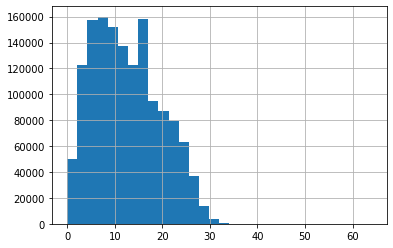

In [13]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [14]:
max_seq_len = 30
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [15]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Creat DataLoaders

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [17]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [18]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
    
      # dense layer 1
      self.lin1 = nn.Linear(768,512)
    
      # relu activation function
      self.relu1 =  nn.ReLU()
      
      # dropout layer
      self.dropout1 = nn.Dropout(0.1)
      
      # dense layer 2 
      self.lin2 = nn.Linear(512,128)
     
      # relu activation function
      self.relu2 = nn.ReLU()
    
      # dropout layer
      self.dropout2 = nn.Dropout(0.1)

      # dense layer 3
      self.lin3 = nn.Linear(128,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.lin1(cls_hs)

      x = self.relu1(x)

      x = self.dropout1(x)
        
      x = self.lin2(x)

      x = self.relu2(x)

      x = self.dropout2(x)

      x = self.lin3(x)

      x = self.softmax(x)

      return x

In [19]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)
# optimizer from hugging face transformers
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)

In [20]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:",class_weights)

# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 
#cross_entropy = nn.CrossEntropyLoss(weight=weights)

# number of training epochs
epochs = 10

Class Weights: [1.00019726 0.99980282]


# Fine-Tune BERT


In [21]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [22]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [23]:
# continue trainning if possible
from os.path import exists
if exists('saved_weights.pt'):
    model.load_state_dict(torch.load('saved_weights.pt'))
    print("Loaded existing model")
    best_valid_loss, _ = evaluate()
else:
    # set initial loss to infinite
    best_valid_loss = float('inf')

Loaded existing model

Evaluating...
  Batch    50  of  5,000.
  Batch   100  of  5,000.
  Batch   150  of  5,000.
  Batch   200  of  5,000.
  Batch   250  of  5,000.
  Batch   300  of  5,000.
  Batch   350  of  5,000.
  Batch   400  of  5,000.
  Batch   450  of  5,000.
  Batch   500  of  5,000.
  Batch   550  of  5,000.
  Batch   600  of  5,000.
  Batch   650  of  5,000.
  Batch   700  of  5,000.
  Batch   750  of  5,000.
  Batch   800  of  5,000.
  Batch   850  of  5,000.
  Batch   900  of  5,000.
  Batch   950  of  5,000.
  Batch 1,000  of  5,000.
  Batch 1,050  of  5,000.
  Batch 1,100  of  5,000.
  Batch 1,150  of  5,000.
  Batch 1,200  of  5,000.
  Batch 1,250  of  5,000.
  Batch 1,300  of  5,000.
  Batch 1,350  of  5,000.
  Batch 1,400  of  5,000.
  Batch 1,450  of  5,000.
  Batch 1,500  of  5,000.
  Batch 1,550  of  5,000.
  Batch 1,600  of  5,000.
  Batch 1,650  of  5,000.
  Batch 1,700  of  5,000.
  Batch 1,750  of  5,000.
  Batch 1,800  of  5,000.
  Batch 1,850  of  5,000.
 

In [24]:

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of  45,000.
  Batch   100  of  45,000.
  Batch   150  of  45,000.
  Batch   200  of  45,000.
  Batch   250  of  45,000.
  Batch   300  of  45,000.
  Batch   350  of  45,000.
  Batch   400  of  45,000.
  Batch   450  of  45,000.
  Batch   500  of  45,000.
  Batch   550  of  45,000.
  Batch   600  of  45,000.
  Batch   650  of  45,000.
  Batch   700  of  45,000.
  Batch   750  of  45,000.
  Batch   800  of  45,000.
  Batch   850  of  45,000.
  Batch   900  of  45,000.
  Batch   950  of  45,000.
  Batch 1,000  of  45,000.
  Batch 1,050  of  45,000.
  Batch 1,100  of  45,000.
  Batch 1,150  of  45,000.
  Batch 1,200  of  45,000.
  Batch 1,250  of  45,000.
  Batch 1,300  of  45,000.
  Batch 1,350  of  45,000.
  Batch 1,400  of  45,000.
  Batch 1,450  of  45,000.
  Batch 1,500  of  45,000.
  Batch 1,550  of  45,000.
  Batch 1,600  of  45,000.
  Batch 1,650  of  45,000.
  Batch 1,700  of  45,000.
  Batch 1,750  of  45,000.
  Batch 1,800  of  45,000.
  Batch 1,850

  Batch 15,050  of  45,000.
  Batch 15,100  of  45,000.
  Batch 15,150  of  45,000.
  Batch 15,200  of  45,000.
  Batch 15,250  of  45,000.
  Batch 15,300  of  45,000.
  Batch 15,350  of  45,000.
  Batch 15,400  of  45,000.
  Batch 15,450  of  45,000.
  Batch 15,500  of  45,000.
  Batch 15,550  of  45,000.
  Batch 15,600  of  45,000.
  Batch 15,650  of  45,000.
  Batch 15,700  of  45,000.
  Batch 15,750  of  45,000.
  Batch 15,800  of  45,000.
  Batch 15,850  of  45,000.
  Batch 15,900  of  45,000.
  Batch 15,950  of  45,000.
  Batch 16,000  of  45,000.
  Batch 16,050  of  45,000.
  Batch 16,100  of  45,000.
  Batch 16,150  of  45,000.
  Batch 16,200  of  45,000.
  Batch 16,250  of  45,000.
  Batch 16,300  of  45,000.
  Batch 16,350  of  45,000.
  Batch 16,400  of  45,000.
  Batch 16,450  of  45,000.
  Batch 16,500  of  45,000.
  Batch 16,550  of  45,000.
  Batch 16,600  of  45,000.
  Batch 16,650  of  45,000.
  Batch 16,700  of  45,000.
  Batch 16,750  of  45,000.
  Batch 16,800  of  

  Batch 29,700  of  45,000.
  Batch 29,750  of  45,000.
  Batch 29,800  of  45,000.
  Batch 29,850  of  45,000.
  Batch 29,900  of  45,000.
  Batch 29,950  of  45,000.
  Batch 30,000  of  45,000.
  Batch 30,050  of  45,000.
  Batch 30,100  of  45,000.
  Batch 30,150  of  45,000.
  Batch 30,200  of  45,000.
  Batch 30,250  of  45,000.
  Batch 30,300  of  45,000.
  Batch 30,350  of  45,000.
  Batch 30,400  of  45,000.
  Batch 30,450  of  45,000.
  Batch 30,500  of  45,000.
  Batch 30,550  of  45,000.
  Batch 30,600  of  45,000.
  Batch 30,650  of  45,000.
  Batch 30,700  of  45,000.
  Batch 30,750  of  45,000.
  Batch 30,800  of  45,000.
  Batch 30,850  of  45,000.
  Batch 30,900  of  45,000.
  Batch 30,950  of  45,000.
  Batch 31,000  of  45,000.
  Batch 31,050  of  45,000.
  Batch 31,100  of  45,000.
  Batch 31,150  of  45,000.
  Batch 31,200  of  45,000.
  Batch 31,250  of  45,000.
  Batch 31,300  of  45,000.
  Batch 31,350  of  45,000.
  Batch 31,400  of  45,000.
  Batch 31,450  of  

  Batch 44,350  of  45,000.
  Batch 44,400  of  45,000.
  Batch 44,450  of  45,000.
  Batch 44,500  of  45,000.
  Batch 44,550  of  45,000.
  Batch 44,600  of  45,000.
  Batch 44,650  of  45,000.
  Batch 44,700  of  45,000.
  Batch 44,750  of  45,000.
  Batch 44,800  of  45,000.
  Batch 44,850  of  45,000.
  Batch 44,900  of  45,000.
  Batch 44,950  of  45,000.

Evaluating...
  Batch    50  of  5,000.
  Batch   100  of  5,000.
  Batch   150  of  5,000.
  Batch   200  of  5,000.
  Batch   250  of  5,000.
  Batch   300  of  5,000.
  Batch   350  of  5,000.
  Batch   400  of  5,000.
  Batch   450  of  5,000.
  Batch   500  of  5,000.
  Batch   550  of  5,000.
  Batch   600  of  5,000.
  Batch   650  of  5,000.
  Batch   700  of  5,000.
  Batch   750  of  5,000.
  Batch   800  of  5,000.
  Batch   850  of  5,000.
  Batch   900  of  5,000.
  Batch   950  of  5,000.
  Batch 1,000  of  5,000.
  Batch 1,050  of  5,000.
  Batch 1,100  of  5,000.
  Batch 1,150  of  5,000.
  Batch 1,200  of  5,00

  Batch 9,650  of  45,000.
  Batch 9,700  of  45,000.
  Batch 9,750  of  45,000.
  Batch 9,800  of  45,000.
  Batch 9,850  of  45,000.
  Batch 9,900  of  45,000.
  Batch 9,950  of  45,000.
  Batch 10,000  of  45,000.
  Batch 10,050  of  45,000.
  Batch 10,100  of  45,000.
  Batch 10,150  of  45,000.
  Batch 10,200  of  45,000.
  Batch 10,250  of  45,000.
  Batch 10,300  of  45,000.
  Batch 10,350  of  45,000.
  Batch 10,400  of  45,000.
  Batch 10,450  of  45,000.
  Batch 10,500  of  45,000.
  Batch 10,550  of  45,000.
  Batch 10,600  of  45,000.
  Batch 10,650  of  45,000.
  Batch 10,700  of  45,000.
  Batch 10,750  of  45,000.
  Batch 10,800  of  45,000.
  Batch 10,850  of  45,000.
  Batch 10,900  of  45,000.
  Batch 10,950  of  45,000.
  Batch 11,000  of  45,000.
  Batch 11,050  of  45,000.
  Batch 11,100  of  45,000.
  Batch 11,150  of  45,000.
  Batch 11,200  of  45,000.
  Batch 11,250  of  45,000.
  Batch 11,300  of  45,000.
  Batch 11,350  of  45,000.
  Batch 11,400  of  45,000.

  Batch 24,300  of  45,000.
  Batch 24,350  of  45,000.
  Batch 24,400  of  45,000.
  Batch 24,450  of  45,000.
  Batch 24,500  of  45,000.
  Batch 24,550  of  45,000.
  Batch 24,600  of  45,000.
  Batch 24,650  of  45,000.
  Batch 24,700  of  45,000.
  Batch 24,750  of  45,000.
  Batch 24,800  of  45,000.
  Batch 24,850  of  45,000.
  Batch 24,900  of  45,000.
  Batch 24,950  of  45,000.
  Batch 25,000  of  45,000.
  Batch 25,050  of  45,000.
  Batch 25,100  of  45,000.
  Batch 25,150  of  45,000.
  Batch 25,200  of  45,000.
  Batch 25,250  of  45,000.
  Batch 25,300  of  45,000.
  Batch 25,350  of  45,000.
  Batch 25,400  of  45,000.
  Batch 25,450  of  45,000.
  Batch 25,500  of  45,000.
  Batch 25,550  of  45,000.
  Batch 25,600  of  45,000.
  Batch 25,650  of  45,000.
  Batch 25,700  of  45,000.
  Batch 25,750  of  45,000.
  Batch 25,800  of  45,000.
  Batch 25,850  of  45,000.
  Batch 25,900  of  45,000.
  Batch 25,950  of  45,000.
  Batch 26,000  of  45,000.
  Batch 26,050  of  

  Batch 38,950  of  45,000.
  Batch 39,000  of  45,000.
  Batch 39,050  of  45,000.
  Batch 39,100  of  45,000.
  Batch 39,150  of  45,000.
  Batch 39,200  of  45,000.
  Batch 39,250  of  45,000.
  Batch 39,300  of  45,000.
  Batch 39,350  of  45,000.
  Batch 39,400  of  45,000.
  Batch 39,450  of  45,000.
  Batch 39,500  of  45,000.
  Batch 39,550  of  45,000.
  Batch 39,600  of  45,000.
  Batch 39,650  of  45,000.
  Batch 39,700  of  45,000.
  Batch 39,750  of  45,000.
  Batch 39,800  of  45,000.
  Batch 39,850  of  45,000.
  Batch 39,900  of  45,000.
  Batch 39,950  of  45,000.
  Batch 40,000  of  45,000.
  Batch 40,050  of  45,000.
  Batch 40,100  of  45,000.
  Batch 40,150  of  45,000.
  Batch 40,200  of  45,000.
  Batch 40,250  of  45,000.
  Batch 40,300  of  45,000.
  Batch 40,350  of  45,000.
  Batch 40,400  of  45,000.
  Batch 40,450  of  45,000.
  Batch 40,500  of  45,000.
  Batch 40,550  of  45,000.
  Batch 40,600  of  45,000.
  Batch 40,650  of  45,000.
  Batch 40,700  of  

  Batch 4,050  of  45,000.
  Batch 4,100  of  45,000.
  Batch 4,150  of  45,000.
  Batch 4,200  of  45,000.
  Batch 4,250  of  45,000.
  Batch 4,300  of  45,000.
  Batch 4,350  of  45,000.
  Batch 4,400  of  45,000.
  Batch 4,450  of  45,000.
  Batch 4,500  of  45,000.
  Batch 4,550  of  45,000.
  Batch 4,600  of  45,000.
  Batch 4,650  of  45,000.
  Batch 4,700  of  45,000.
  Batch 4,750  of  45,000.
  Batch 4,800  of  45,000.
  Batch 4,850  of  45,000.
  Batch 4,900  of  45,000.
  Batch 4,950  of  45,000.
  Batch 5,000  of  45,000.
  Batch 5,050  of  45,000.
  Batch 5,100  of  45,000.
  Batch 5,150  of  45,000.
  Batch 5,200  of  45,000.
  Batch 5,250  of  45,000.
  Batch 5,300  of  45,000.
  Batch 5,350  of  45,000.
  Batch 5,400  of  45,000.
  Batch 5,450  of  45,000.
  Batch 5,500  of  45,000.
  Batch 5,550  of  45,000.
  Batch 5,600  of  45,000.
  Batch 5,650  of  45,000.
  Batch 5,700  of  45,000.
  Batch 5,750  of  45,000.
  Batch 5,800  of  45,000.
  Batch 5,850  of  45,000.
 

  Batch 18,900  of  45,000.
  Batch 18,950  of  45,000.
  Batch 19,000  of  45,000.
  Batch 19,050  of  45,000.
  Batch 19,100  of  45,000.
  Batch 19,150  of  45,000.
  Batch 19,200  of  45,000.
  Batch 19,250  of  45,000.
  Batch 19,300  of  45,000.
  Batch 19,350  of  45,000.
  Batch 19,400  of  45,000.
  Batch 19,450  of  45,000.
  Batch 19,500  of  45,000.
  Batch 19,550  of  45,000.
  Batch 19,600  of  45,000.
  Batch 19,650  of  45,000.
  Batch 19,700  of  45,000.
  Batch 19,750  of  45,000.
  Batch 19,800  of  45,000.
  Batch 19,850  of  45,000.
  Batch 19,900  of  45,000.
  Batch 19,950  of  45,000.
  Batch 20,000  of  45,000.
  Batch 20,050  of  45,000.
  Batch 20,100  of  45,000.
  Batch 20,150  of  45,000.
  Batch 20,200  of  45,000.
  Batch 20,250  of  45,000.
  Batch 20,300  of  45,000.
  Batch 20,350  of  45,000.
  Batch 20,400  of  45,000.
  Batch 20,450  of  45,000.
  Batch 20,500  of  45,000.
  Batch 20,550  of  45,000.
  Batch 20,600  of  45,000.
  Batch 20,650  of  

  Batch 33,550  of  45,000.
  Batch 33,600  of  45,000.
  Batch 33,650  of  45,000.
  Batch 33,700  of  45,000.
  Batch 33,750  of  45,000.
  Batch 33,800  of  45,000.
  Batch 33,850  of  45,000.
  Batch 33,900  of  45,000.
  Batch 33,950  of  45,000.
  Batch 34,000  of  45,000.
  Batch 34,050  of  45,000.
  Batch 34,100  of  45,000.
  Batch 34,150  of  45,000.
  Batch 34,200  of  45,000.
  Batch 34,250  of  45,000.
  Batch 34,300  of  45,000.
  Batch 34,350  of  45,000.
  Batch 34,400  of  45,000.
  Batch 34,450  of  45,000.
  Batch 34,500  of  45,000.
  Batch 34,550  of  45,000.
  Batch 34,600  of  45,000.
  Batch 34,650  of  45,000.
  Batch 34,700  of  45,000.
  Batch 34,750  of  45,000.
  Batch 34,800  of  45,000.
  Batch 34,850  of  45,000.
  Batch 34,900  of  45,000.
  Batch 34,950  of  45,000.
  Batch 35,000  of  45,000.
  Batch 35,050  of  45,000.
  Batch 35,100  of  45,000.
  Batch 35,150  of  45,000.
  Batch 35,200  of  45,000.
  Batch 35,250  of  45,000.
  Batch 35,300  of  

  Batch 3,450  of  5,000.
  Batch 3,500  of  5,000.
  Batch 3,550  of  5,000.
  Batch 3,600  of  5,000.
  Batch 3,650  of  5,000.
  Batch 3,700  of  5,000.
  Batch 3,750  of  5,000.
  Batch 3,800  of  5,000.
  Batch 3,850  of  5,000.
  Batch 3,900  of  5,000.
  Batch 3,950  of  5,000.
  Batch 4,000  of  5,000.
  Batch 4,050  of  5,000.
  Batch 4,100  of  5,000.
  Batch 4,150  of  5,000.
  Batch 4,200  of  5,000.
  Batch 4,250  of  5,000.
  Batch 4,300  of  5,000.
  Batch 4,350  of  5,000.
  Batch 4,400  of  5,000.
  Batch 4,450  of  5,000.
  Batch 4,500  of  5,000.
  Batch 4,550  of  5,000.
  Batch 4,600  of  5,000.
  Batch 4,650  of  5,000.
  Batch 4,700  of  5,000.
  Batch 4,750  of  5,000.
  Batch 4,800  of  5,000.
  Batch 4,850  of  5,000.
  Batch 4,900  of  5,000.
  Batch 4,950  of  5,000.

Training Loss: 0.511
Validation Loss: 0.485

 Epoch 4 / 10
  Batch    50  of  45,000.
  Batch   100  of  45,000.
  Batch   150  of  45,000.
  Batch   200  of  45,000.
  Batch   250  of  45,000.

  Batch 13,500  of  45,000.
  Batch 13,550  of  45,000.
  Batch 13,600  of  45,000.
  Batch 13,650  of  45,000.
  Batch 13,700  of  45,000.
  Batch 13,750  of  45,000.
  Batch 13,800  of  45,000.
  Batch 13,850  of  45,000.
  Batch 13,900  of  45,000.
  Batch 13,950  of  45,000.
  Batch 14,000  of  45,000.
  Batch 14,050  of  45,000.
  Batch 14,100  of  45,000.
  Batch 14,150  of  45,000.
  Batch 14,200  of  45,000.
  Batch 14,250  of  45,000.
  Batch 14,300  of  45,000.
  Batch 14,350  of  45,000.
  Batch 14,400  of  45,000.
  Batch 14,450  of  45,000.
  Batch 14,500  of  45,000.
  Batch 14,550  of  45,000.
  Batch 14,600  of  45,000.
  Batch 14,650  of  45,000.
  Batch 14,700  of  45,000.
  Batch 14,750  of  45,000.
  Batch 14,800  of  45,000.
  Batch 14,850  of  45,000.
  Batch 14,900  of  45,000.
  Batch 14,950  of  45,000.
  Batch 15,000  of  45,000.
  Batch 15,050  of  45,000.
  Batch 15,100  of  45,000.
  Batch 15,150  of  45,000.
  Batch 15,200  of  45,000.
  Batch 15,250  of  

  Batch 28,150  of  45,000.
  Batch 28,200  of  45,000.
  Batch 28,250  of  45,000.
  Batch 28,300  of  45,000.
  Batch 28,350  of  45,000.
  Batch 28,400  of  45,000.
  Batch 28,450  of  45,000.
  Batch 28,500  of  45,000.
  Batch 28,550  of  45,000.
  Batch 28,600  of  45,000.
  Batch 28,650  of  45,000.
  Batch 28,700  of  45,000.
  Batch 28,750  of  45,000.
  Batch 28,800  of  45,000.
  Batch 28,850  of  45,000.
  Batch 28,900  of  45,000.
  Batch 28,950  of  45,000.
  Batch 29,000  of  45,000.
  Batch 29,050  of  45,000.
  Batch 29,100  of  45,000.
  Batch 29,150  of  45,000.
  Batch 29,200  of  45,000.
  Batch 29,250  of  45,000.
  Batch 29,300  of  45,000.
  Batch 29,350  of  45,000.
  Batch 29,400  of  45,000.
  Batch 29,450  of  45,000.
  Batch 29,500  of  45,000.
  Batch 29,550  of  45,000.
  Batch 29,600  of  45,000.
  Batch 29,650  of  45,000.
  Batch 29,700  of  45,000.
  Batch 29,750  of  45,000.
  Batch 29,800  of  45,000.
  Batch 29,850  of  45,000.
  Batch 29,900  of  

  Batch 42,800  of  45,000.
  Batch 42,850  of  45,000.
  Batch 42,900  of  45,000.
  Batch 42,950  of  45,000.
  Batch 43,000  of  45,000.
  Batch 43,050  of  45,000.
  Batch 43,100  of  45,000.
  Batch 43,150  of  45,000.
  Batch 43,200  of  45,000.
  Batch 43,250  of  45,000.
  Batch 43,300  of  45,000.
  Batch 43,350  of  45,000.
  Batch 43,400  of  45,000.
  Batch 43,450  of  45,000.
  Batch 43,500  of  45,000.
  Batch 43,550  of  45,000.
  Batch 43,600  of  45,000.
  Batch 43,650  of  45,000.
  Batch 43,700  of  45,000.
  Batch 43,750  of  45,000.
  Batch 43,800  of  45,000.
  Batch 43,850  of  45,000.
  Batch 43,900  of  45,000.
  Batch 43,950  of  45,000.
  Batch 44,000  of  45,000.
  Batch 44,050  of  45,000.
  Batch 44,100  of  45,000.
  Batch 44,150  of  45,000.
  Batch 44,200  of  45,000.
  Batch 44,250  of  45,000.
  Batch 44,300  of  45,000.
  Batch 44,350  of  45,000.
  Batch 44,400  of  45,000.
  Batch 44,450  of  45,000.
  Batch 44,500  of  45,000.
  Batch 44,550  of  

  Batch 8,050  of  45,000.
  Batch 8,100  of  45,000.
  Batch 8,150  of  45,000.
  Batch 8,200  of  45,000.
  Batch 8,250  of  45,000.
  Batch 8,300  of  45,000.
  Batch 8,350  of  45,000.
  Batch 8,400  of  45,000.
  Batch 8,450  of  45,000.
  Batch 8,500  of  45,000.
  Batch 8,550  of  45,000.
  Batch 8,600  of  45,000.
  Batch 8,650  of  45,000.
  Batch 8,700  of  45,000.
  Batch 8,750  of  45,000.
  Batch 8,800  of  45,000.
  Batch 8,850  of  45,000.
  Batch 8,900  of  45,000.
  Batch 8,950  of  45,000.
  Batch 9,000  of  45,000.
  Batch 9,050  of  45,000.
  Batch 9,100  of  45,000.
  Batch 9,150  of  45,000.
  Batch 9,200  of  45,000.
  Batch 9,250  of  45,000.
  Batch 9,300  of  45,000.
  Batch 9,350  of  45,000.
  Batch 9,400  of  45,000.
  Batch 9,450  of  45,000.
  Batch 9,500  of  45,000.
  Batch 9,550  of  45,000.
  Batch 9,600  of  45,000.
  Batch 9,650  of  45,000.
  Batch 9,700  of  45,000.
  Batch 9,750  of  45,000.
  Batch 9,800  of  45,000.
  Batch 9,850  of  45,000.
 

  Batch 22,750  of  45,000.
  Batch 22,800  of  45,000.
  Batch 22,850  of  45,000.
  Batch 22,900  of  45,000.
  Batch 22,950  of  45,000.
  Batch 23,000  of  45,000.
  Batch 23,050  of  45,000.
  Batch 23,100  of  45,000.
  Batch 23,150  of  45,000.
  Batch 23,200  of  45,000.
  Batch 23,250  of  45,000.
  Batch 23,300  of  45,000.
  Batch 23,350  of  45,000.
  Batch 23,400  of  45,000.
  Batch 23,450  of  45,000.
  Batch 23,500  of  45,000.
  Batch 23,550  of  45,000.
  Batch 23,600  of  45,000.
  Batch 23,650  of  45,000.
  Batch 23,700  of  45,000.
  Batch 23,750  of  45,000.
  Batch 23,800  of  45,000.
  Batch 23,850  of  45,000.
  Batch 23,900  of  45,000.
  Batch 23,950  of  45,000.
  Batch 24,000  of  45,000.
  Batch 24,050  of  45,000.
  Batch 24,100  of  45,000.
  Batch 24,150  of  45,000.
  Batch 24,200  of  45,000.
  Batch 24,250  of  45,000.
  Batch 24,300  of  45,000.
  Batch 24,350  of  45,000.
  Batch 24,400  of  45,000.
  Batch 24,450  of  45,000.
  Batch 24,500  of  

  Batch 37,400  of  45,000.
  Batch 37,450  of  45,000.
  Batch 37,500  of  45,000.
  Batch 37,550  of  45,000.
  Batch 37,600  of  45,000.
  Batch 37,650  of  45,000.
  Batch 37,700  of  45,000.
  Batch 37,750  of  45,000.
  Batch 37,800  of  45,000.
  Batch 37,850  of  45,000.
  Batch 37,900  of  45,000.
  Batch 37,950  of  45,000.
  Batch 38,000  of  45,000.
  Batch 38,050  of  45,000.
  Batch 38,100  of  45,000.
  Batch 38,150  of  45,000.
  Batch 38,200  of  45,000.
  Batch 38,250  of  45,000.
  Batch 38,300  of  45,000.
  Batch 38,350  of  45,000.
  Batch 38,400  of  45,000.
  Batch 38,450  of  45,000.
  Batch 38,500  of  45,000.
  Batch 38,550  of  45,000.
  Batch 38,600  of  45,000.
  Batch 38,650  of  45,000.
  Batch 38,700  of  45,000.
  Batch 38,750  of  45,000.
  Batch 38,800  of  45,000.
  Batch 38,850  of  45,000.
  Batch 38,900  of  45,000.
  Batch 38,950  of  45,000.
  Batch 39,000  of  45,000.
  Batch 39,050  of  45,000.
  Batch 39,100  of  45,000.
  Batch 39,150  of  

  Batch 2,450  of  45,000.
  Batch 2,500  of  45,000.
  Batch 2,550  of  45,000.
  Batch 2,600  of  45,000.
  Batch 2,650  of  45,000.
  Batch 2,700  of  45,000.
  Batch 2,750  of  45,000.
  Batch 2,800  of  45,000.
  Batch 2,850  of  45,000.
  Batch 2,900  of  45,000.
  Batch 2,950  of  45,000.
  Batch 3,000  of  45,000.
  Batch 3,050  of  45,000.
  Batch 3,100  of  45,000.
  Batch 3,150  of  45,000.
  Batch 3,200  of  45,000.
  Batch 3,250  of  45,000.
  Batch 3,300  of  45,000.
  Batch 3,350  of  45,000.
  Batch 3,400  of  45,000.
  Batch 3,450  of  45,000.
  Batch 3,500  of  45,000.
  Batch 3,550  of  45,000.
  Batch 3,600  of  45,000.
  Batch 3,650  of  45,000.
  Batch 3,700  of  45,000.
  Batch 3,750  of  45,000.
  Batch 3,800  of  45,000.
  Batch 3,850  of  45,000.
  Batch 3,900  of  45,000.
  Batch 3,950  of  45,000.
  Batch 4,000  of  45,000.
  Batch 4,050  of  45,000.
  Batch 4,100  of  45,000.
  Batch 4,150  of  45,000.
  Batch 4,200  of  45,000.
  Batch 4,250  of  45,000.
 

  Batch 17,350  of  45,000.
  Batch 17,400  of  45,000.
  Batch 17,450  of  45,000.
  Batch 17,500  of  45,000.
  Batch 17,550  of  45,000.
  Batch 17,600  of  45,000.
  Batch 17,650  of  45,000.
  Batch 17,700  of  45,000.
  Batch 17,750  of  45,000.
  Batch 17,800  of  45,000.
  Batch 17,850  of  45,000.
  Batch 17,900  of  45,000.
  Batch 17,950  of  45,000.
  Batch 18,000  of  45,000.
  Batch 18,050  of  45,000.
  Batch 18,100  of  45,000.
  Batch 18,150  of  45,000.
  Batch 18,200  of  45,000.
  Batch 18,250  of  45,000.
  Batch 18,300  of  45,000.
  Batch 18,350  of  45,000.
  Batch 18,400  of  45,000.
  Batch 18,450  of  45,000.
  Batch 18,500  of  45,000.
  Batch 18,550  of  45,000.
  Batch 18,600  of  45,000.
  Batch 18,650  of  45,000.
  Batch 18,700  of  45,000.
  Batch 18,750  of  45,000.
  Batch 18,800  of  45,000.
  Batch 18,850  of  45,000.
  Batch 18,900  of  45,000.
  Batch 18,950  of  45,000.
  Batch 19,000  of  45,000.
  Batch 19,050  of  45,000.
  Batch 19,100  of  

  Batch 32,000  of  45,000.
  Batch 32,050  of  45,000.
  Batch 32,100  of  45,000.
  Batch 32,150  of  45,000.
  Batch 32,200  of  45,000.
  Batch 32,250  of  45,000.
  Batch 32,300  of  45,000.
  Batch 32,350  of  45,000.
  Batch 32,400  of  45,000.
  Batch 32,450  of  45,000.
  Batch 32,500  of  45,000.
  Batch 32,550  of  45,000.
  Batch 32,600  of  45,000.
  Batch 32,650  of  45,000.
  Batch 32,700  of  45,000.
  Batch 32,750  of  45,000.
  Batch 32,800  of  45,000.
  Batch 32,850  of  45,000.
  Batch 32,900  of  45,000.
  Batch 32,950  of  45,000.
  Batch 33,000  of  45,000.
  Batch 33,050  of  45,000.
  Batch 33,100  of  45,000.
  Batch 33,150  of  45,000.
  Batch 33,200  of  45,000.
  Batch 33,250  of  45,000.
  Batch 33,300  of  45,000.
  Batch 33,350  of  45,000.
  Batch 33,400  of  45,000.
  Batch 33,450  of  45,000.
  Batch 33,500  of  45,000.
  Batch 33,550  of  45,000.
  Batch 33,600  of  45,000.
  Batch 33,650  of  45,000.
  Batch 33,700  of  45,000.
  Batch 33,750  of  

  Batch 1,800  of  5,000.
  Batch 1,850  of  5,000.
  Batch 1,900  of  5,000.
  Batch 1,950  of  5,000.
  Batch 2,000  of  5,000.
  Batch 2,050  of  5,000.
  Batch 2,100  of  5,000.
  Batch 2,150  of  5,000.
  Batch 2,200  of  5,000.
  Batch 2,250  of  5,000.
  Batch 2,300  of  5,000.
  Batch 2,350  of  5,000.
  Batch 2,400  of  5,000.
  Batch 2,450  of  5,000.
  Batch 2,500  of  5,000.
  Batch 2,550  of  5,000.
  Batch 2,600  of  5,000.
  Batch 2,650  of  5,000.
  Batch 2,700  of  5,000.
  Batch 2,750  of  5,000.
  Batch 2,800  of  5,000.
  Batch 2,850  of  5,000.
  Batch 2,900  of  5,000.
  Batch 2,950  of  5,000.
  Batch 3,000  of  5,000.
  Batch 3,050  of  5,000.
  Batch 3,100  of  5,000.
  Batch 3,150  of  5,000.
  Batch 3,200  of  5,000.
  Batch 3,250  of  5,000.
  Batch 3,300  of  5,000.
  Batch 3,350  of  5,000.
  Batch 3,400  of  5,000.
  Batch 3,450  of  5,000.
  Batch 3,500  of  5,000.
  Batch 3,550  of  5,000.
  Batch 3,600  of  5,000.
  Batch 3,650  of  5,000.
  Batch 3,70

  Batch 12,000  of  45,000.
  Batch 12,050  of  45,000.
  Batch 12,100  of  45,000.
  Batch 12,150  of  45,000.
  Batch 12,200  of  45,000.
  Batch 12,250  of  45,000.
  Batch 12,300  of  45,000.
  Batch 12,350  of  45,000.
  Batch 12,400  of  45,000.
  Batch 12,450  of  45,000.
  Batch 12,500  of  45,000.
  Batch 12,550  of  45,000.
  Batch 12,600  of  45,000.
  Batch 12,650  of  45,000.
  Batch 12,700  of  45,000.
  Batch 12,750  of  45,000.
  Batch 12,800  of  45,000.
  Batch 12,850  of  45,000.
  Batch 12,900  of  45,000.
  Batch 12,950  of  45,000.
  Batch 13,000  of  45,000.
  Batch 13,050  of  45,000.
  Batch 13,100  of  45,000.
  Batch 13,150  of  45,000.
  Batch 13,200  of  45,000.
  Batch 13,250  of  45,000.
  Batch 13,300  of  45,000.
  Batch 13,350  of  45,000.
  Batch 13,400  of  45,000.
  Batch 13,450  of  45,000.
  Batch 13,500  of  45,000.
  Batch 13,550  of  45,000.
  Batch 13,600  of  45,000.
  Batch 13,650  of  45,000.
  Batch 13,700  of  45,000.
  Batch 13,750  of  

  Batch 26,650  of  45,000.
  Batch 26,700  of  45,000.
  Batch 26,750  of  45,000.
  Batch 26,800  of  45,000.
  Batch 26,850  of  45,000.
  Batch 26,900  of  45,000.
  Batch 26,950  of  45,000.
  Batch 27,000  of  45,000.
  Batch 27,050  of  45,000.
  Batch 27,100  of  45,000.
  Batch 27,150  of  45,000.
  Batch 27,200  of  45,000.
  Batch 27,250  of  45,000.
  Batch 27,300  of  45,000.
  Batch 27,350  of  45,000.
  Batch 27,400  of  45,000.
  Batch 27,450  of  45,000.
  Batch 27,500  of  45,000.
  Batch 27,550  of  45,000.
  Batch 27,600  of  45,000.
  Batch 27,650  of  45,000.
  Batch 27,700  of  45,000.
  Batch 27,750  of  45,000.
  Batch 27,800  of  45,000.
  Batch 27,850  of  45,000.
  Batch 27,900  of  45,000.
  Batch 27,950  of  45,000.
  Batch 28,000  of  45,000.
  Batch 28,050  of  45,000.
  Batch 28,100  of  45,000.
  Batch 28,150  of  45,000.
  Batch 28,200  of  45,000.
  Batch 28,250  of  45,000.
  Batch 28,300  of  45,000.
  Batch 28,350  of  45,000.
  Batch 28,400  of  

  Batch 41,300  of  45,000.
  Batch 41,350  of  45,000.
  Batch 41,400  of  45,000.
  Batch 41,450  of  45,000.
  Batch 41,500  of  45,000.
  Batch 41,550  of  45,000.
  Batch 41,600  of  45,000.
  Batch 41,650  of  45,000.
  Batch 41,700  of  45,000.
  Batch 41,750  of  45,000.
  Batch 41,800  of  45,000.
  Batch 41,850  of  45,000.
  Batch 41,900  of  45,000.
  Batch 41,950  of  45,000.
  Batch 42,000  of  45,000.
  Batch 42,050  of  45,000.
  Batch 42,100  of  45,000.
  Batch 42,150  of  45,000.
  Batch 42,200  of  45,000.
  Batch 42,250  of  45,000.
  Batch 42,300  of  45,000.
  Batch 42,350  of  45,000.
  Batch 42,400  of  45,000.
  Batch 42,450  of  45,000.
  Batch 42,500  of  45,000.
  Batch 42,550  of  45,000.
  Batch 42,600  of  45,000.
  Batch 42,650  of  45,000.
  Batch 42,700  of  45,000.
  Batch 42,750  of  45,000.
  Batch 42,800  of  45,000.
  Batch 42,850  of  45,000.
  Batch 42,900  of  45,000.
  Batch 42,950  of  45,000.
  Batch 43,000  of  45,000.
  Batch 43,050  of  

  Batch 6,500  of  45,000.
  Batch 6,550  of  45,000.
  Batch 6,600  of  45,000.
  Batch 6,650  of  45,000.
  Batch 6,700  of  45,000.
  Batch 6,750  of  45,000.
  Batch 6,800  of  45,000.
  Batch 6,850  of  45,000.
  Batch 6,900  of  45,000.
  Batch 6,950  of  45,000.
  Batch 7,000  of  45,000.
  Batch 7,050  of  45,000.
  Batch 7,100  of  45,000.
  Batch 7,150  of  45,000.
  Batch 7,200  of  45,000.
  Batch 7,250  of  45,000.
  Batch 7,300  of  45,000.
  Batch 7,350  of  45,000.
  Batch 7,400  of  45,000.
  Batch 7,450  of  45,000.
  Batch 7,500  of  45,000.
  Batch 7,550  of  45,000.
  Batch 7,600  of  45,000.
  Batch 7,650  of  45,000.
  Batch 7,700  of  45,000.
  Batch 7,750  of  45,000.
  Batch 7,800  of  45,000.
  Batch 7,850  of  45,000.
  Batch 7,900  of  45,000.
  Batch 7,950  of  45,000.
  Batch 8,000  of  45,000.
  Batch 8,050  of  45,000.
  Batch 8,100  of  45,000.
  Batch 8,150  of  45,000.
  Batch 8,200  of  45,000.
  Batch 8,250  of  45,000.
  Batch 8,300  of  45,000.
 

  Batch 21,300  of  45,000.
  Batch 21,350  of  45,000.
  Batch 21,400  of  45,000.
  Batch 21,450  of  45,000.
  Batch 21,500  of  45,000.
  Batch 21,550  of  45,000.
  Batch 21,600  of  45,000.
  Batch 21,650  of  45,000.
  Batch 21,700  of  45,000.
  Batch 21,750  of  45,000.
  Batch 21,800  of  45,000.
  Batch 21,850  of  45,000.
  Batch 21,900  of  45,000.
  Batch 21,950  of  45,000.
  Batch 22,000  of  45,000.
  Batch 22,050  of  45,000.
  Batch 22,100  of  45,000.
  Batch 22,150  of  45,000.
  Batch 22,200  of  45,000.
  Batch 22,250  of  45,000.
  Batch 22,300  of  45,000.
  Batch 22,350  of  45,000.
  Batch 22,400  of  45,000.
  Batch 22,450  of  45,000.
  Batch 22,500  of  45,000.
  Batch 22,550  of  45,000.
  Batch 22,600  of  45,000.
  Batch 22,650  of  45,000.
  Batch 22,700  of  45,000.
  Batch 22,750  of  45,000.
  Batch 22,800  of  45,000.
  Batch 22,850  of  45,000.
  Batch 22,900  of  45,000.
  Batch 22,950  of  45,000.
  Batch 23,000  of  45,000.
  Batch 23,050  of  

  Batch 35,950  of  45,000.
  Batch 36,000  of  45,000.
  Batch 36,050  of  45,000.
  Batch 36,100  of  45,000.
  Batch 36,150  of  45,000.
  Batch 36,200  of  45,000.
  Batch 36,250  of  45,000.
  Batch 36,300  of  45,000.
  Batch 36,350  of  45,000.
  Batch 36,400  of  45,000.
  Batch 36,450  of  45,000.
  Batch 36,500  of  45,000.
  Batch 36,550  of  45,000.
  Batch 36,600  of  45,000.
  Batch 36,650  of  45,000.
  Batch 36,700  of  45,000.
  Batch 36,750  of  45,000.
  Batch 36,800  of  45,000.
  Batch 36,850  of  45,000.
  Batch 36,900  of  45,000.
  Batch 36,950  of  45,000.
  Batch 37,000  of  45,000.
  Batch 37,050  of  45,000.
  Batch 37,100  of  45,000.
  Batch 37,150  of  45,000.
  Batch 37,200  of  45,000.
  Batch 37,250  of  45,000.
  Batch 37,300  of  45,000.
  Batch 37,350  of  45,000.
  Batch 37,400  of  45,000.
  Batch 37,450  of  45,000.
  Batch 37,500  of  45,000.
  Batch 37,550  of  45,000.
  Batch 37,600  of  45,000.
  Batch 37,650  of  45,000.
  Batch 37,700  of  

  Batch   950  of  45,000.
  Batch 1,000  of  45,000.
  Batch 1,050  of  45,000.
  Batch 1,100  of  45,000.
  Batch 1,150  of  45,000.
  Batch 1,200  of  45,000.
  Batch 1,250  of  45,000.
  Batch 1,300  of  45,000.
  Batch 1,350  of  45,000.
  Batch 1,400  of  45,000.
  Batch 1,450  of  45,000.
  Batch 1,500  of  45,000.
  Batch 1,550  of  45,000.
  Batch 1,600  of  45,000.
  Batch 1,650  of  45,000.
  Batch 1,700  of  45,000.
  Batch 1,750  of  45,000.
  Batch 1,800  of  45,000.
  Batch 1,850  of  45,000.
  Batch 1,900  of  45,000.
  Batch 1,950  of  45,000.
  Batch 2,000  of  45,000.
  Batch 2,050  of  45,000.
  Batch 2,100  of  45,000.
  Batch 2,150  of  45,000.
  Batch 2,200  of  45,000.
  Batch 2,250  of  45,000.
  Batch 2,300  of  45,000.
  Batch 2,350  of  45,000.
  Batch 2,400  of  45,000.
  Batch 2,450  of  45,000.
  Batch 2,500  of  45,000.
  Batch 2,550  of  45,000.
  Batch 2,600  of  45,000.
  Batch 2,650  of  45,000.
  Batch 2,700  of  45,000.
  Batch 2,750  of  45,000.
 

  Batch 15,950  of  45,000.
  Batch 16,000  of  45,000.
  Batch 16,050  of  45,000.
  Batch 16,100  of  45,000.
  Batch 16,150  of  45,000.
  Batch 16,200  of  45,000.
  Batch 16,250  of  45,000.
  Batch 16,300  of  45,000.
  Batch 16,350  of  45,000.
  Batch 16,400  of  45,000.
  Batch 16,450  of  45,000.
  Batch 16,500  of  45,000.
  Batch 16,550  of  45,000.
  Batch 16,600  of  45,000.
  Batch 16,650  of  45,000.
  Batch 16,700  of  45,000.
  Batch 16,750  of  45,000.
  Batch 16,800  of  45,000.
  Batch 16,850  of  45,000.
  Batch 16,900  of  45,000.
  Batch 16,950  of  45,000.
  Batch 17,000  of  45,000.
  Batch 17,050  of  45,000.
  Batch 17,100  of  45,000.
  Batch 17,150  of  45,000.
  Batch 17,200  of  45,000.
  Batch 17,250  of  45,000.
  Batch 17,300  of  45,000.
  Batch 17,350  of  45,000.
  Batch 17,400  of  45,000.
  Batch 17,450  of  45,000.
  Batch 17,500  of  45,000.
  Batch 17,550  of  45,000.
  Batch 17,600  of  45,000.
  Batch 17,650  of  45,000.
  Batch 17,700  of  

  Batch 30,600  of  45,000.
  Batch 30,650  of  45,000.
  Batch 30,700  of  45,000.
  Batch 30,750  of  45,000.
  Batch 30,800  of  45,000.
  Batch 30,850  of  45,000.
  Batch 30,900  of  45,000.
  Batch 30,950  of  45,000.
  Batch 31,000  of  45,000.
  Batch 31,050  of  45,000.
  Batch 31,100  of  45,000.
  Batch 31,150  of  45,000.
  Batch 31,200  of  45,000.
  Batch 31,250  of  45,000.
  Batch 31,300  of  45,000.
  Batch 31,350  of  45,000.
  Batch 31,400  of  45,000.
  Batch 31,450  of  45,000.
  Batch 31,500  of  45,000.
  Batch 31,550  of  45,000.
  Batch 31,600  of  45,000.
  Batch 31,650  of  45,000.
  Batch 31,700  of  45,000.
  Batch 31,750  of  45,000.
  Batch 31,800  of  45,000.
  Batch 31,850  of  45,000.
  Batch 31,900  of  45,000.
  Batch 31,950  of  45,000.
  Batch 32,000  of  45,000.
  Batch 32,050  of  45,000.
  Batch 32,100  of  45,000.
  Batch 32,150  of  45,000.
  Batch 32,200  of  45,000.
  Batch 32,250  of  45,000.
  Batch 32,300  of  45,000.
  Batch 32,350  of  

  Batch   300  of  5,000.
  Batch   350  of  5,000.
  Batch   400  of  5,000.
  Batch   450  of  5,000.
  Batch   500  of  5,000.
  Batch   550  of  5,000.
  Batch   600  of  5,000.
  Batch   650  of  5,000.
  Batch   700  of  5,000.
  Batch   750  of  5,000.
  Batch   800  of  5,000.
  Batch   850  of  5,000.
  Batch   900  of  5,000.
  Batch   950  of  5,000.
  Batch 1,000  of  5,000.
  Batch 1,050  of  5,000.
  Batch 1,100  of  5,000.
  Batch 1,150  of  5,000.
  Batch 1,200  of  5,000.
  Batch 1,250  of  5,000.
  Batch 1,300  of  5,000.
  Batch 1,350  of  5,000.
  Batch 1,400  of  5,000.
  Batch 1,450  of  5,000.
  Batch 1,500  of  5,000.
  Batch 1,550  of  5,000.
  Batch 1,600  of  5,000.
  Batch 1,650  of  5,000.
  Batch 1,700  of  5,000.
  Batch 1,750  of  5,000.
  Batch 1,800  of  5,000.
  Batch 1,850  of  5,000.
  Batch 1,900  of  5,000.
  Batch 1,950  of  5,000.
  Batch 2,000  of  5,000.
  Batch 2,050  of  5,000.
  Batch 2,100  of  5,000.
  Batch 2,150  of  5,000.
  Batch 2,20

  Batch 10,600  of  45,000.
  Batch 10,650  of  45,000.
  Batch 10,700  of  45,000.
  Batch 10,750  of  45,000.
  Batch 10,800  of  45,000.
  Batch 10,850  of  45,000.
  Batch 10,900  of  45,000.
  Batch 10,950  of  45,000.
  Batch 11,000  of  45,000.
  Batch 11,050  of  45,000.
  Batch 11,100  of  45,000.
  Batch 11,150  of  45,000.
  Batch 11,200  of  45,000.
  Batch 11,250  of  45,000.
  Batch 11,300  of  45,000.
  Batch 11,350  of  45,000.
  Batch 11,400  of  45,000.
  Batch 11,450  of  45,000.
  Batch 11,500  of  45,000.
  Batch 11,550  of  45,000.
  Batch 11,600  of  45,000.
  Batch 11,650  of  45,000.
  Batch 11,700  of  45,000.
  Batch 11,750  of  45,000.
  Batch 11,800  of  45,000.
  Batch 11,850  of  45,000.
  Batch 11,900  of  45,000.
  Batch 11,950  of  45,000.
  Batch 12,000  of  45,000.
  Batch 12,050  of  45,000.
  Batch 12,100  of  45,000.
  Batch 12,150  of  45,000.
  Batch 12,200  of  45,000.
  Batch 12,250  of  45,000.
  Batch 12,300  of  45,000.
  Batch 12,350  of  

  Batch 25,250  of  45,000.
  Batch 25,300  of  45,000.
  Batch 25,350  of  45,000.
  Batch 25,400  of  45,000.
  Batch 25,450  of  45,000.
  Batch 25,500  of  45,000.
  Batch 25,550  of  45,000.
  Batch 25,600  of  45,000.
  Batch 25,650  of  45,000.
  Batch 25,700  of  45,000.
  Batch 25,750  of  45,000.
  Batch 25,800  of  45,000.
  Batch 25,850  of  45,000.
  Batch 25,900  of  45,000.
  Batch 25,950  of  45,000.
  Batch 26,000  of  45,000.
  Batch 26,050  of  45,000.
  Batch 26,100  of  45,000.
  Batch 26,150  of  45,000.
  Batch 26,200  of  45,000.
  Batch 26,250  of  45,000.
  Batch 26,300  of  45,000.
  Batch 26,350  of  45,000.
  Batch 26,400  of  45,000.
  Batch 26,450  of  45,000.
  Batch 26,500  of  45,000.
  Batch 26,550  of  45,000.
  Batch 26,600  of  45,000.
  Batch 26,650  of  45,000.
  Batch 26,700  of  45,000.
  Batch 26,750  of  45,000.
  Batch 26,800  of  45,000.
  Batch 26,850  of  45,000.
  Batch 26,900  of  45,000.
  Batch 26,950  of  45,000.
  Batch 27,000  of  

  Batch 39,900  of  45,000.
  Batch 39,950  of  45,000.
  Batch 40,000  of  45,000.
  Batch 40,050  of  45,000.
  Batch 40,100  of  45,000.
  Batch 40,150  of  45,000.
  Batch 40,200  of  45,000.
  Batch 40,250  of  45,000.
  Batch 40,300  of  45,000.
  Batch 40,350  of  45,000.
  Batch 40,400  of  45,000.
  Batch 40,450  of  45,000.
  Batch 40,500  of  45,000.
  Batch 40,550  of  45,000.
  Batch 40,600  of  45,000.
  Batch 40,650  of  45,000.
  Batch 40,700  of  45,000.
  Batch 40,750  of  45,000.
  Batch 40,800  of  45,000.
  Batch 40,850  of  45,000.
  Batch 40,900  of  45,000.
  Batch 40,950  of  45,000.
  Batch 41,000  of  45,000.
  Batch 41,050  of  45,000.
  Batch 41,100  of  45,000.
  Batch 41,150  of  45,000.
  Batch 41,200  of  45,000.
  Batch 41,250  of  45,000.
  Batch 41,300  of  45,000.
  Batch 41,350  of  45,000.
  Batch 41,400  of  45,000.
  Batch 41,450  of  45,000.
  Batch 41,500  of  45,000.
  Batch 41,550  of  45,000.
  Batch 41,600  of  45,000.
  Batch 41,650  of  

# Load Saved Model

In [25]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [26]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [27]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       177
           1       0.84      0.87      0.85       182

    accuracy                           0.85       359
   macro avg       0.85      0.85      0.85       359
weighted avg       0.85      0.85      0.85       359



In [28]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,147,30
1,24,158
